# Let's determine our initial values for the mmi

In [ ]:
import meow as mw
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['pcolor.shading'] ="auto"
from skill_challenge.util import cachedComputeModes

In [ ]:
env = mw.Environment(
    wl=1.55,
    T=27,
)

def create_geometry(L=1e3, w=2.3, t_core=0.4, offset=0):
    slab_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-10,
            x_max=10,
            y_min=-2.0,
            y_max=2.0,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    core = mw.Structure(
        material=mw.silicon_nitride,
        geometry=mw.Box(
            x_min=-w / 2 + offset,
            x_max=w / 2  + offset,
            y_min=0.0,
            y_max=t_core,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    return [slab_ox, core]

In [ ]:
def construct_css(L):
    w_tot = 5
    mesh = mw.Mesh2d(  # decrease approx_dy for more accuracy
                x=np.linspace(-w_tot/2-1,w_tot/2+1,100),
                y=np.linspace(-1.5,1.5,100)
            )
    c_mmi = mw.Cell(
            structures=create_geometry(w=w_tot),
            mesh=mesh,
            z_min=0,
            z_max=L,
        )
    c_launch = mw.Cell(
            structures=create_geometry(w=0.9, offset=w_tot/6+1),
            mesh=mesh,
            z_min=0,
            z_max=0,
        )
    
    c_receive = mw.Cell(
            structures=create_geometry(w=0.9, offset=w_tot/6+1),
            mesh=mesh,
            z_min=L,
            z_max=L,
        )

    css = [mw.CrossSection(
        cell=cell,
        env=env,
    ) for cell in [c_launch, c_mmi]]
    
    return css

In [ ]:
css = construct_css(1e3)

/opt/conda/lib/python3.9/site-packages/matplotlib/text.py:825: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/opt/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/opt/conda/lib/python3.9/site-packages/matplotlib/text.py:685: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(textobj.convert_yunits(textobj._y))


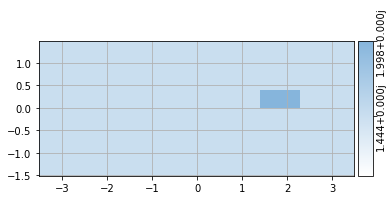

In [ ]:
mw.vis(css[0])

In [ ]:
modes = [cachedComputeModes(cs, num_modes=10) for cs in css]
te_modes = [m for m in modes[1] if np.real(m.te_fraction)>0.5]

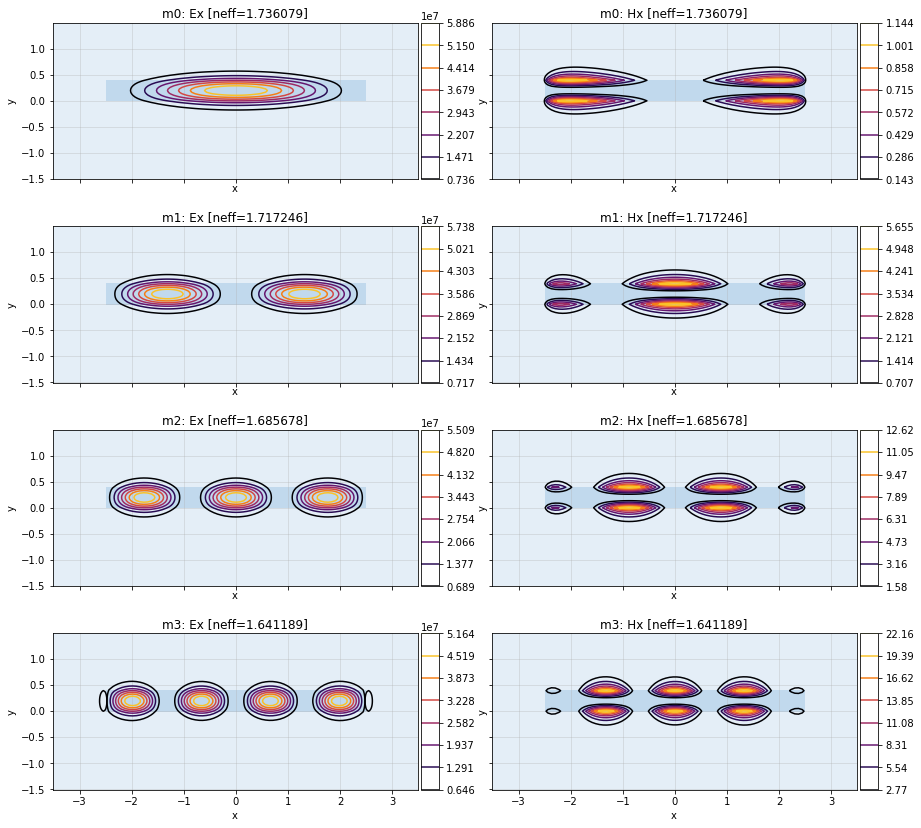

In [ ]:
mw.vis(te_modes[:4])

In [ ]:
k0 = 2*np.pi/env.wl
l_pi = np.pi/(k0*te_modes[0].neff-k0*te_modes[1].neff)
l_pi = np.real(l_pi)

In [ ]:
l_pi*3/2

6.173e+01

In [ ]:
from meow.eme.propagate import propagate_modes
ex_l = np.zeros(10)
ex_r = np.zeros(10)
ex_l[0] = 1

L = l_pi*3
z = np.linspace(0,L,1000)
y = 0.2

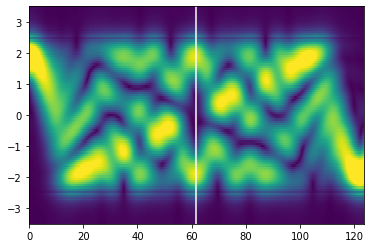

In [ ]:
E, x = propagate_modes(modes, ex_l, ex_r, y, z)
X, Y = np.meshgrid(z, x)
lim = np.quantile(np.abs(E), 0.98)
plt.pcolormesh(X, Y, np.abs(E).T, shading="nearest", vmin=0, vmax=lim)
plt.axvline(L/2, color="w")

# Note to calculate the s-parameters we will have to introduce ports to meow

{'left@0': 0, 'left@1': 1, 'left@2': 2, 'left@3': 3, 'left@4': 4, 'left@5': 5, 'left@6': 6, 'left@7': 7, 'left@8': 8, 'left@9': 9, 'left@10': 10, 'left@11': 11, 'right@0': 12, 'right@1': 13, 'right@2': 14, 'right@3': 15, 'right@4': 16, 'right@5': 17, 'right@6': 18, 'right@7': 19, 'right@8': 20, 'right@9': 21, 'right@10': 22, 'right@11': 23}


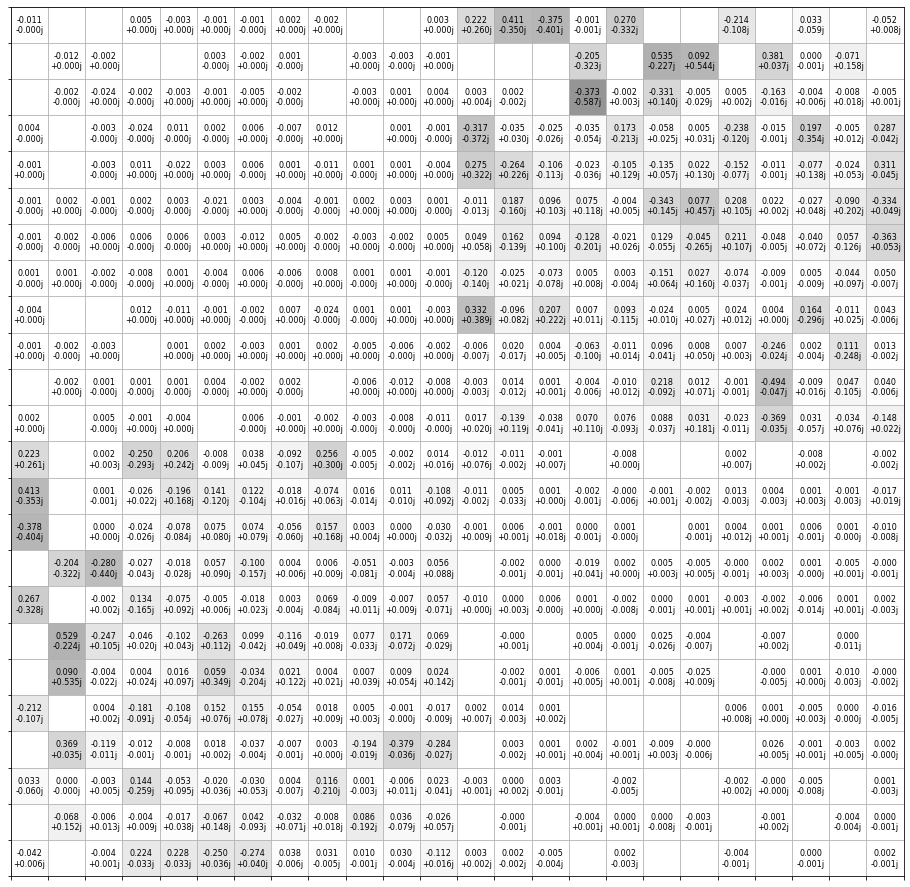

In [ ]:
css = construct_css(l_pi*3/2)
modes = [cachedComputeModes(cs, num_modes=12) for cs in css]
S, port_map = mw.compute_s_matrix(modes)
print(port_map)
mw.visualize(S)